In [1]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import numpy as np
import torch
import dotenv
dotenv.load_dotenv()
# https://colab.research.google.com/drive/17dQFYUYnuKnP6OwQPH9v_GSYUW5aj-Rp#scrollTo=v6ZlLW2J5LA8

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
torch.set_grad_enabled(False) # avoid blowing up mem

model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    device_map='cuda',
)
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


In [3]:
# The input text
prompt = "Would you be able to travel through time using a wormhole?"

# Use the tokenizer to convert it to tokens. Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs)

# Pass it in to the model and generate text
outputs = model.generate(input_ids=inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

tensor([[     2,  18925,    692,    614,   3326,    577,   5056,   1593,   1069,
           2177,    476,  47420,  18216, 235336]], device='cuda:0')
<bos>Would you be able to travel through time using a wormhole?

[Answer 1]

Yes, you can travel through time using a wormhole.

A wormhole is a theoretical object that connects two points in space-time. It is a tunnel through space-time that allows objects to travel from


In [4]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=10004)
IFrame(html, width=1200, height=600)

In [5]:
interp_latent_idx = 10_004 # we should use this one!
from sae_lens import SAE  # pip install sae-lens

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_20/width_16k/canonical",
)
sae.cuda()


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [6]:

def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

In [ ]:
target_act = gather_residual_activations(model, 20, inputs)
sae_acts = sae.encode(target_act.to(torch.float32))
recon = sae.decode(sae_acts)
1 - torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) **2) / (target_act[:, 1:].to(torch.float32).var())
(sae_acts > 1).sum(-1)

tensor([[7017,   47,   65,   70,   55,   72,   65,   75,   80,   72,   68,   93,
           86,   89]], device='cuda:0')

In [8]:
target_act.shape

torch.Size([1, 14, 2304])

In [9]:
values, inds = sae_acts.max(-1)

inds

tensor([[ 6631,  5482, 10376,  1670, 11023,  7562,  9407,  8399, 12935, 10004,
         10004, 10004, 12935,  3442]], device='cuda:0')

In [10]:
from transformer_lens.utils import tokenize_and_concatenate
from datasets import load_dataset
# dataset_name = "EleutherAI/the_pile_deduplicated" # too big?
# dataset_name = "stas/openwebtext-10k" # yolo
dataset_name = "PatrickHaller/pile-10M-words"
dataset = load_dataset(dataset_name, split="train", trust_remote_code=True) # Smaller version
# print(dataset)
# raise NotImplementedError("Stop here")
tokens = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)['tokens']
tokens = tokens.to('cuda') # eh 

In [11]:
tokens.shape

torch.Size([107803, 128])

In [12]:
model.eval()
for p in model.parameters():
    p.requires_grad = False
    p.grad = None

In [13]:
# turns out width over 2 works?
with torch.no_grad():
    model(tokens[:1])

In [14]:
try:
    del collected_outputs
except:
    pass
import gc
gc.collect()
torch.cuda.empty_cache()
import tqdm
collected_outputs = []
less_tokens = tokens[:10_000] # eh
def gather_target_act_hook(mod, inputs, outputs):
    global collected_outputs
    assert isinstance(outputs, tuple)
    assert len(outputs) == 1 and isinstance(outputs[0], torch.Tensor), f"Expected a single tensor output, got {outputs}" # fmt: skip
    collected_outputs.append(outputs[0].detach().requires_grad_(False).cpu())
    return outputs
handle = model.model.layers[20].register_forward_hook(gather_target_act_hook)
try:
    batch_size = 100
    for i in tqdm.trange(0, less_tokens.shape[0], batch_size):
        j = min(i + batch_size, less_tokens.shape[0])
        model.forward(less_tokens[i:j])
finally:
    handle.remove()
collected_outputs = torch.cat(collected_outputs, dim=0)
print(collected_outputs.shape)

100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


torch.Size([10000, 128, 2304])


In [15]:
tokens_is_special = (less_tokens == tokenizer.bos_token_id) | (less_tokens == tokenizer.eos_token_id) | (less_tokens == tokenizer.pad_token_id)
# print(tokens_is_special.shape)
tokens_is_special_flat = tokens_is_special.cpu().flatten()
# print(tokens_is_special_flat.shape)
collected_outputs_flat = collected_outputs.cpu().reshape(-1, collected_outputs.shape[-1])
# print(collected_outputs_flat.shape)
activations = collected_outputs_flat[~tokens_is_special_flat, :]
print(activations.shape)

torch.Size([1266193, 2304])


In [16]:
activations = activations.to("cuda")


In [17]:
relevant_idxs_and_names = [
    (10_004, "spacetime_latent_idx"),
    (15_947, "boolean_assignments_in_code"),
    (6_166, "conditional_statements_and_boolean_expressions"),
    (2_290, "boolean_declarations_and_related_expressions"),
    (6_223, "boolean_expressions_and_condition_checks"),
    (9_096, "syntax_related_to_boolean_operations_and_conditions"),
    (6_612, "instances_of_numbers_and_counting"),
    (13_046, "numbers_and_symbols_in_text"),
    (12_732, "instances_of_the_word_the_and_numbers"),
    (5_401, "references_to_numbers_and_quantitative_data"),
    (7_746, "numbers_and_quantities_related_to_time"),
    (6_850, "repetition_of_the_word_number"),
    (16_095, "references_to_number_one"),
    (11_520, "terms_and_definitions_related_to_numbers"),
    (6_010, "numbers_and_mathematical_operations"),
    (4_723, "numbers_and_specific_dates"),
    (2_437, "patterns_related_to_numerical_information"),
    (6_275, "numbers_and_numerical_values_in_context"),
    (15_031, "numbers_and_codes_related_to_legal_references"),
    (10_738, "phrases_related_to_numbers_and_mathematical_representations"),
    (2_269, "structured_lists_or_numbered_steps"),
    (11_576, "presence_of_numerical_values_or_references_to_numbered_steps"),
    (9_560, "numbers_and_their_combinations_in_various_contexts"),
    (11_669, "patterns_represented_by_sequences_of_numbers"),
    (12_115, "mentions_of_in_x_followed_by_a_number"),
    (1_561, "phrases_related_to_numbers_and_statistics"),
    (382, "numbers_and_their_associated_quantities"),
    (15_763, "sequences_of_numbers_and_their_occurrences"),
    (8_974, "phrases_indicating_quantity_or_comparison_involving_numbers"),
    (3_219, "numbers_and_their_associated_representations"),
    (2_260, "numbers_and_numerical_data"),
    (9_856, "numbers_associated_with_logical_operations"),
    (10_427, "numbers_and_their_formats"),
    (11_301, "integers_and_numbers_in_different_formats"),
    (11_626, "numbers_related_to_measurements_or_statistics"),
    (12_457, "sequences_of_numbers_and_codes_related_to_programming"),
    (12_841, "sequences_of_numbers_representing_activation_values"),
    (6_541, "numbers_and_numeric_expressions_in_academic_contexts"),
    (15_483, "numbers_dates_or_numerical_sequences"),
    (8_900, "numerical_information_related_to_phone_numbers"),
    (13_730, "numbers_and_alphanumeric_codes"),
    (14_853, "decimal_numbers_and_numeric_identifiers"),
    (972, "references_to_numbers_in_social_or_legal_context"),
    (12_852, "the_number_i_in_various_contexts"),
    (2_074, "numbers_represented_in_decimal_format"),
    (7_466, "presence_of_text_format_elements_like_numbers"),
    (16_183, "programming_functions_related_to_parsing_numbers"),
    (5_022, "code_snippets_related_to_phone_number_formatting"),
    (8_718, "numbers_and_symbols_in_non_standard_formats"),
    (43, "references_to_number_of_bedrooms"),
    (303, "mathematical_operations_related_to_rounding_numbers"),
    (723, "formatting_numbers_and_datetime_representations"),
    (1_589, "numbers_and_numerical_references_in_documents"),
    (6_057, "numbers_indicating_statistical_data"),
    (6_567, "sequences_of_numbers_and_code_structure"),
    (7_062, "integer_and_floating_point_numbers_in_programming"),
    (9_945, "occurrences_of_numbers_in_text"),
    (10_970, "numbers_and_their_operations_in_code"),
    (11_360, "contact_information_particularly_phone_numbers"),
    (11_663, "numbers_and_statistical_data_from_research"),
    (11_708, "references_to_phone_numbers"),
    (11_771, "references_to_section_numbers_in_documents"),
    (12_567, "specific_numeric_values_such_as_phone_numbers"),
    (14_355, "java_programming_constructs_for_numeric_data_types"),
    (10_779, "integers_related_to_success_or_completion_statuses"),
    (10_917, "declarations_of_integer_variables_in_programming"),
    (8_916, "terms_related_to_sizes_and_lengths"),
    (11_952, "phrases_that_emphasize_perspectives"),
    (2_579, "relational_conditions_involving_size_or_counts"),
    (10_999, "size_specifications_in_programming_contexts"),
    (6_276, "programming_syntax_dealing_with_sizes_and_dimensions"),
    (13_826, "screen_size_and_viewport_configurations"),
    (1_275, "terms_related_to_size_ranking_and_excellence"),
    (16_216, "references_to_size_and_dimensions"),
    (5_885, "phrases_emphasizing_outcomes_or_conclusions"),
    (14_202, "comparative_phrases_relating_to_size_or_status"),
    (5_862, "comparison_and_evaluation_about_size"),
    (7_508, "quantifiers_and_discussions_of_scale"),
    (7_097, "sentences_emphasizing_personal_reflections"),
    (387, "phrases_emphasizing_singular_focus"),
    (10_905, "repetitive_phrases_emphasizing_certainty"),
    (5_981, "phrases_emphasizing_significance_of_the"),
    (11_504, "comparisons_of_size_and_value"),
    (16_079, "adverbs_emphasizing_totality"),
    (1_058, "phrases_emphasizing_examples"),
    (9_348, "intensifiers_emphasizing_degree_or_quality"),
    (5_665, "phrases_emphasizing_totality"),
    (10_239, "references_to_size_or_magnitude"),
    (12_848, "measurements_related_to_distances_and_sizes"),
    (13_101, "intensifiers_emphasizing_attribute_degree"),
    (12_795, "bold_or_strongly_emphasized_text"),
    (640, "method_calls_related_to_size"),
    (1_323, "phrases_emphasizing_leadership"),
    (1_439, "variables_and_their_sizes_in_code"),
    (1_603, "intensifiers_emphasizing_quantity"),
    (4_385, "phrases_emphasizing_online_platforms"),
    (4_635, "phrases_emphasizing_value_creation"),
    (4_773, "phrases_emphasizing_personal_style"),
    (6_769, "phrases_emphasizing_beliefs_about_reality"),
    (6_829, "phrases_emphasizing_inclusivity"),
    (7_654, "measurements_related_to_distances_and_sizes"),
    (7_694, "phrases_emphasizing_reflection_time"),
    (9_626, "phrases_emphasizing_effort_and_improvement"),
    (9_903, "quotations_and_emphasized_statements"),
    (10_240, "phrases_emphasizing_caution_and_detail"),
    (10_323, "memory_allocation_and_size_calculations"),
    (12_390, "repeated_or_emphasized_phrases"),
    (12_609, "conjunctive_phrases_emphasizing_collaboration"),
    (13_202, "references_to_size_in_various_contexts"),
    (13_555, "measurements_related_to_size_and_pressure"),
    (14_289, "numerical_data_related_to_size_or_quantity"),
    (1_757, "mathematical_concepts_in_geometry_and_topology"),
    (1_939, "mathematical_notation_for_algebra_and_geometry"),
    (443, "mathematical_concepts_in_geometry_and_polygons"),
    (6_893, "concepts_related_to_geometry_and_dimensional_spaces"),
    (8_903, "technical_terms_in_advanced_mathematics_and_geometry"),
    (10_331, "phrases_emphasizing_personal_aspirations"),
    (7_458, "sample_sizes_in_research_contexts"),
    (2_083, "comparative_adjectives_related_to_size"),
    (1_019, "attributes_related_to_font_size_in_code"),
    (12_609, "conjunctive_phrases_emphasizing_collaboration"),
    (13_202, "references_to_size_in_various_contexts"),
    (13_555, "measurements_related_to_size_and_pressure"),
    (14_289, "numerical_data_related_to_size_or_quantity"),
    (8_916, "terms_related_to_sizes_and_lengths"),
    (2_579, "relational_conditions_involving_length_and_size"),
    (1_439, "variables_and_their_sizes_or_lengths_in_code"),
    (7_294, "references_to_length_in_scientific_contexts"),
    (8_538, "occurrences_of_len_and_length_related_terms"),
    (15_816, "phrases_related_to_lengths_and_measurements"),
]
# Remove duplicates from the list above
unique_dict = {}
for idx, name in relevant_idxs_and_names:
    unique_dict[idx] = unique_dict.get(idx, name)
relevant_idxs_and_names = [(idx, name) for idx, name in unique_dict.items()]


print(f"Original list length: {len(relevant_idxs_and_names)}")
print(f"After removing duplicates: {len(relevant_idxs_and_names)}")

assert len(set([idx for idx, _ in relevant_idxs_and_names])) == len(relevant_idxs_and_names)
idx2latents = {}
batch_size = 1000
assert activations.ndim == 2, f"activations.shape = {activations.shape}"
for i in tqdm.trange(0, activations.shape[0], batch_size):
    j = min(i + batch_size, activations.shape[0])
    latents = sae.encode(activations[i:j])
    for idx, idx_name in relevant_idxs_and_names:
        if idx not in idx2latents:
            idx2latents[idx] = []
        idx2latents[idx].append(latents[:, idx].detach().requires_grad_(False).clone().cpu())
for idx in idx2latents:
    idx2latents[idx] = torch.cat(idx2latents[idx], dim=0)
idx2sums = {idx: latents.sum(dim=0) for idx, latents in idx2latents.items()}
idx2counts = {idx: (latents != 0).sum(dim=0) for idx, latents in idx2latents.items()}
idx2variances = {idx: latents.pow(2).sum(dim=0) / idx2counts[idx] for idx, latents in idx2latents.items()}
idx2stdevs = {idx: torch.sqrt(idx2variances[idx]) for idx in idx2variances}


Original list length: 123
After removing duplicates: 123


100%|██████████| 1267/1267 [00:09<00:00, 135.46it/s]


In [18]:
# interp_latent_idx = 10_004
# spacetime_latents = latents[interp_latent_idx]
# spacetime_latents.shape
# histo_data = spacetime_latents.cpu().numpy()
# histo_data2 = histo_data[histo_data != 0]
# print("histo_data.shape", histo_data.shape)
# print("histo_data2.shape", histo_data2.shape)
import json
print(json.dumps({x: f"n_samples={y.shape[0]:2e} stdev={idx2stdevs[x].item():2f} {unique_dict[x]}" for x, y in sorted(idx2latents.items(), key=lambda x: idx2stdevs[x[0]])}, indent=4))

{
    "7466": "n_samples=1.266193e+06 stdev=8.657542 presence_of_text_format_elements_like_numbers",
    "6612": "n_samples=1.266193e+06 stdev=8.969367 instances_of_numbers_and_counting",
    "6223": "n_samples=1.266193e+06 stdev=8.980078 boolean_expressions_and_condition_checks",
    "16183": "n_samples=1.266193e+06 stdev=9.012576 programming_functions_related_to_parsing_numbers",
    "6166": "n_samples=1.266193e+06 stdev=9.299420 conditional_statements_and_boolean_expressions",
    "2579": "n_samples=1.266193e+06 stdev=9.333973 relational_conditions_involving_size_or_counts",
    "1439": "n_samples=1.266193e+06 stdev=9.349107 variables_and_their_sizes_in_code",
    "12852": "n_samples=1.266193e+06 stdev=9.412748 the_number_i_in_various_contexts",
    "7062": "n_samples=1.266193e+06 stdev=9.727068 integer_and_floating_point_numbers_in_programming",
    "12841": "n_samples=1.266193e+06 stdev=9.787866 sequences_of_numbers_representing_activation_values",
    "2074": "n_samples=1.266193e

In [19]:
idx2means = {idx: idx2sums[idx] / idx2counts[idx] for idx in idx2sums}
print(json.dumps({x: f"n_samples={y.shape[0]:2e} mean={idx2means[x].item():2f} {unique_dict[x]}" for x, y in sorted(idx2latents.items(), key=lambda x: idx2means[x[0]])}, indent=4))

{
    "7466": "n_samples=1.266193e+06 mean=8.583406 presence_of_text_format_elements_like_numbers",
    "16183": "n_samples=1.266193e+06 mean=8.823438 programming_functions_related_to_parsing_numbers",
    "6612": "n_samples=1.266193e+06 mean=8.847377 instances_of_numbers_and_counting",
    "2579": "n_samples=1.266193e+06 mean=8.891475 relational_conditions_involving_size_or_counts",
    "6223": "n_samples=1.266193e+06 mean=8.914431 boolean_expressions_and_condition_checks",
    "6166": "n_samples=1.266193e+06 mean=8.991830 conditional_statements_and_boolean_expressions",
    "12852": "n_samples=1.266193e+06 mean=9.050463 the_number_i_in_various_contexts",
    "1439": "n_samples=1.266193e+06 mean=9.144050 variables_and_their_sizes_in_code",
    "7062": "n_samples=1.266193e+06 mean=9.415812 integer_and_floating_point_numbers_in_programming",
    "11520": "n_samples=1.266193e+06 mean=9.554384 terms_and_definitions_related_to_numbers",
    "12841": "n_samples=1.266193e+06 mean=9.604994 se

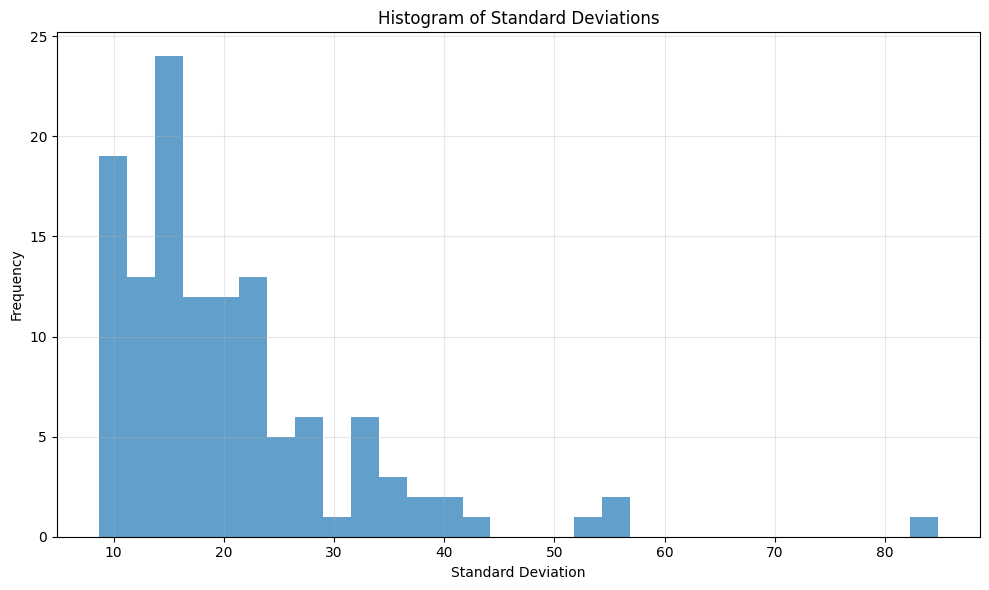

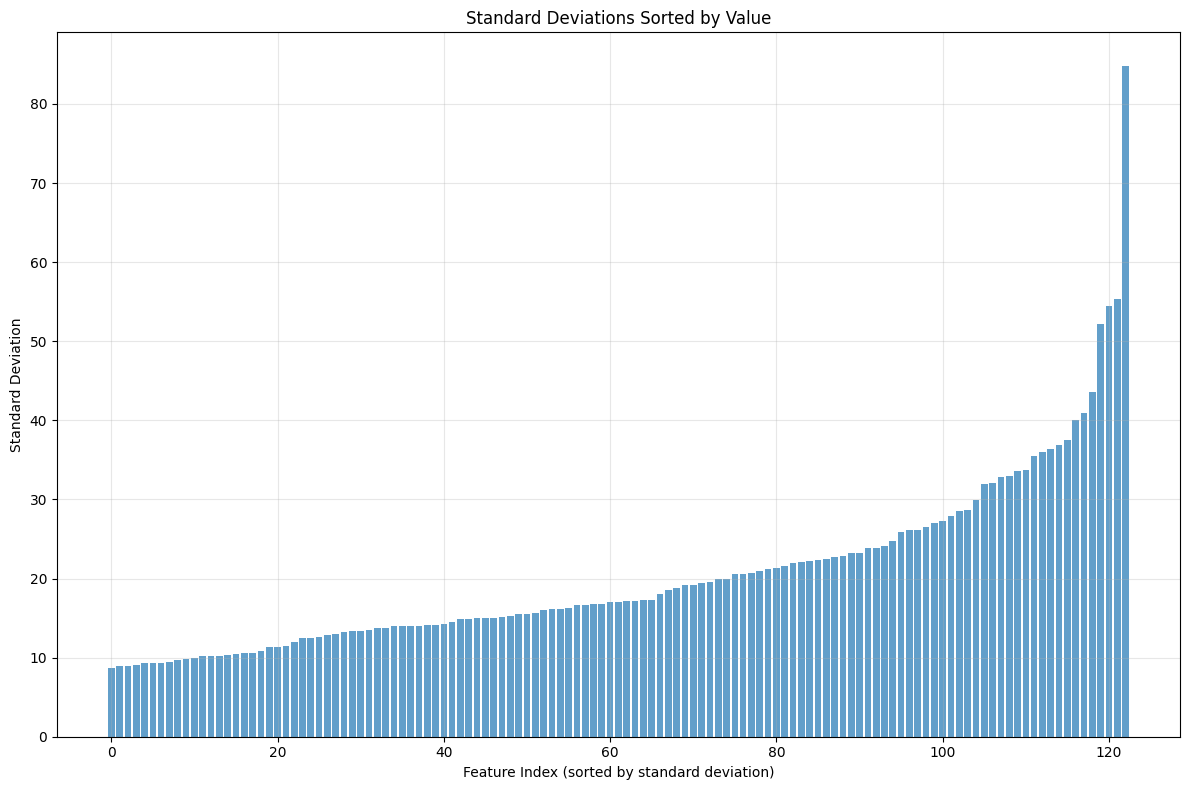

Min standard deviation: 8.65754222869873
Max standard deviation: 84.81404113769531
Mean standard deviation: 20.48973846435547


In [20]:
import matplotlib.pyplot as plt
# Plot histogram of standard deviations
plt.figure(figsize=(10, 6))
stdevs = [idx2stdevs[idx] for idx in sorted(idx2stdevs.keys())]
plt.hist(stdevs, bins=30, alpha=0.7)
plt.title('Histogram of Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Also plot the distribution of standard deviations with feature names
plt.figure(figsize=(12, 8))
sorted_idxs = sorted(idx2stdevs.keys(), key=lambda x: idx2stdevs[x])
sorted_stdevs = [idx2stdevs[idx] for idx in sorted_idxs]
plt.bar(range(len(sorted_stdevs)), sorted_stdevs, alpha=0.7)
plt.title('Standard Deviations Sorted by Value')
plt.xlabel('Feature Index (sorted by standard deviation)')
plt.ylabel('Standard Deviation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics about the standard deviations
print(f"Min standard deviation: {min(stdevs)}")
print(f"Max standard deviation: {max(stdevs)}")
print(f"Mean standard deviation: {sum(stdevs)/len(stdevs)}")


In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
output_folder = Path("deleteme_sae_dist_plots")
output_folder.mkdir(exist_ok=False)
for idx, idx_name in tqdm.tqdm(relevant_idxs_and_names):
    filename = output_folder / (idx_name.replace(".", "_").replace("/", "_") + ".png")
    latents = idx2latents[idx]
    histo_data = latents.cpu().numpy()
    histo_data2 = histo_data[histo_data != 0]
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Set an overall title to the idx_name
    fig.suptitle(f"{idx_name} (idx={idx}) Histogram of Distributions")

    # Plot histogram of all data (histo_data)
    ax1.hist(histo_data, bins=50, alpha=0.7)
    ax1.set_title('Histogram of All Latent Values')
    ax1.set_xlabel('Latent Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(alpha=0.3)

    # Plot histogram of non-zero data (histo_data2)
    ax2.hist(histo_data2, bins=50, alpha=0.7)
    ax2.set_title('Histogram of Non-Zero Latent Values')
    ax2.set_xlabel('Latent Value')
    ax2.set_ylabel('Frequency')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    # plt.show()
    # Save the figure to the specified filename
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free memory



FileExistsError: [Errno 17] File exists: 'deleteme_sae_dist_plots'

In [ ]:
boolean_assignments_in_code_idx = 15_947

In [26]:
import tqdm
# Let's try and display all deez
for idx, idx_name in tqdm.tqdm(relevant_idxs_and_names):
    # template_link =
    # html = get_dashboard_html(sae_release = "gemma-scope-2b-pt-res-canonical", sae_id="layer_20/width_16k/canonical", feature_idx=idx)
    # x = IFrame(html, width=1200, height=600)
    # display(x)
    # "gemma-2-2b", sae_id="20-gemmascope-res-16k"
    print(html_template.format("gemma-2-2b", "20-gemmascope-res-16k", idx))

100%|██████████| 123/123 [00:00<00:00, 55437.29it/s]

https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/10004?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/15947?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6166?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/2290?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6223?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/9096?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6612?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-g

In [59]:
import torch.nn as nn
from typing import Dict
class IdxMapQuantizedS(nn.Module):
    def __init__(self, sae: SAE, idx2means: Dict[int, torch.Tensor]):
        super().__init__()
        self.sae = sae
        self.idx2means = idx2means
        self.zero = torch.tensor(0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        enc = self.sae.encode(x)
        for idx, mean in self.idx2means.items():
            enc[:, :, idx] = enc[:, :, idx].where(enc[:, :, idx] > 0, mean)
        decoded = self.sae.decode(enc)
        assert decoded.shape == x.shape
        return decoded

less_tokens = tokens[:10_000] # eh
print(less_tokens.shape)
all_quantized = IdxMapQuantizedS(sae, idx2means)
def gather_target_act_hook(mod, inputs, outputs):
    global all_quantized
    assert isinstance(outputs, tuple)
    input_pt = inputs[0]
    return all_quantized(input_pt)
handle = model.model.layers[20].register_forward_hook(gather_target_act_hook)
try:
    batch_size = 100
    for i in tqdm.trange(0, less_tokens.shape[0], batch_size):
        j = min(i + batch_size, less_tokens.shape[0])
        out = model.forward(less_tokens[i:j])
        # out = model(torch.randint(0, 10000, (batch_size, 128), device="cuda"))
        print(out)
        raise NotImplementedError("Stop here")
finally:
    handle.remove()

torch.Size([10000, 128])


  0%|          | 0/100 [00:01<?, ?it/s]


RuntimeError: The size of tensor a (8) must match the size of tensor b (256) at non-singleton dimension 3